# Quantum Auto-Regressive Model Training
**Objective:** Train a Hybrid Quantum-Classical Neural Network to predict the next token in a molecular sequence, conditioned on global molecular properties (logP, QED, MW).

**Architecture:**
* **Input:** 5-bit token encodings + 3 continuous property values.
* **Ansatz:** A variational quantum circuit using Strongly Entangling Layers and Diagonal Phase rotations ($e^{-i \phi Z \otimes Z}$).
* **Training:** JAX-based optimization using the Adam optimizer.

In [1]:
from typing import Tuple, List, Dict, Any

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import QED
from rdkit.Chem import Draw
from IPython.display import display
import selfies as sf

import numpy as np
import math
from math import ceil, log2, comb
import re
import pandas as pd
import optax
import csv
import json
import itertools
from functools import partial
import time
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle

import pennylane as qml
from pennylane.templates import StronglyEntanglingLayers

import jax
import jax.random as random
from jax import random
import jax.numpy as jnp
import jax.nn as jnn
from jax.nn.initializers import normal


# Data Preparation

In [2]:
# Load metadata from JSON
N_MOLECS = 500
META_DATA_PATH = f"../data/metadata_selfies_{N_MOLECS}.json"
TIMESTAMP = time.strftime("%d%m%Y_%H")

with open(META_DATA_PATH, "r") as f:
    metadata = json.load(f)

VOCABULARY_SIZE = metadata['vocabulary_size']
BITS_PER_TOKEN = metadata['bits_per_token']
MAX_LEN = metadata['max_sequence_length']
ALPHABET = metadata['alphabet']
min_logp = metadata['min_logP']
max_logp = metadata['max_logP']
min_qed = metadata['min_qed']
max_qed = metadata['max_qed']
min_mw = metadata['min_mw']
max_mw = metadata['max_mw']

print("Vocabulary Size:", VOCABULARY_SIZE)
print("Bits per Token:", BITS_PER_TOKEN)
print("Max Sequence Length:", MAX_LEN)
print("Alphabet:", ALPHABET)


Vocabulary Size: 29
Bits per Token: 5
Max Sequence Length: 31
Alphabet: ['<SOS>', '[#Branch1]', '[#Branch2]', '[#C]', '[=Branch1]', '[=Branch2]', '[=C]', '[=N]', '[=O]', '[=P]', '[=Ring1]', '[=S]', '[Br]', '[Branch1]', '[Branch2]', '[C]', '[Cl]', '[F]', '[I]', '[NH1]', '[N]', '[O]', '[PH1]', '[P]', '[Ring1]', '[Ring2]', '[S]', '<EOS>', '<PAD>']


In [3]:
# --- Auxiliary functions ---

def normalize(value, min_val, max_val, target_max=np.pi):
    ''' Normalize a value to a range [0, [0, pi] to later encode them as rotation angles'''
    norm = (value - min_val) / (max_val - min_val) * target_max
    return float(f"{norm:.3f}")

def denormalize(norm_value, min_val, max_val, target_max=np.pi):
    ''' Denormalize a value from [0, pi] back to its original range'''
    return (norm_value * (max_val - min_val) / target_max) + min_val

def token_to_index(token):
    ''' Map a SELFIES token to its corresponding index in the ALPHABET'''
    if token in ALPHABET:
        return ALPHABET.index(token)
    else:
        return None

def bits_to_index(bits):
    powers = 2 ** jnp.arange(len(bits) - 1, -1, -1)
    return jnp.dot(bits, powers).astype(jnp.int32)

In [4]:
PAD_index = token_to_index("<PAD>")
SOS_index = token_to_index("<SOS>")
EOS_index = token_to_index("<EOS>")

In [5]:
def load_dataset_bits_batch(csv_path, n_bits=BITS_PER_TOKEN):
    """
    Read the dataset from a CSV file and convert it into bit representations for quantum processing.
    Args:
        csv_path (str): Path to the CSV file containing the dataset.
        n_bits (int): Number of bits used to represent each token.
    Returns:
        Tuple containing:
            - X_bits (jnp.ndarray): Input bit representations of shape (N_Molecules, MAX_LEN-1, n_bits).
            - Props (jnp.ndarray): Molecular properties of shape (N_Molecules, 3).
            - Y_indices (jnp.ndarray): Target token indices of shape (N_Molecules, MAX_LEN-1).
    """
    
    df = pd.read_csv(csv_path, dtype=str)
    print("Dataset loaded with shape:", df.shape)
    
    # Properties: logP, qed, mw
    # Shape: (N_Moleculas, 3)
    # Types: float
    props = df.iloc[:, :3].astype(float).values
    
    # Tokens
    # Shape: (N_Moleculas, MAX_LEN)
    # Types: string (e.g., "00101")
    token_cols = df.iloc[:, 3:].values
    
    # Auxiliary function to convert a string of '0's and '1's to a list
    def str_to_bit_list(s):
        return [int(c) for c in s]

    # 3D array to hold all bits
    all_bits = np.array([
        [str_to_bit_list(token) for token in row] 
        for row in token_cols
    ])
    
    # X_bits: Input for the model.
    # Take all tokens except the last one.
    X_bits = all_bits[:, :-1, :] 
    
    # Y_ind: Target indices for the model.
    # Take all tokens except the first one.
    # Convert from bit strings to integer indices (for loss calculation).
    Y_indices = np.array([[int(t, 2) for t in row[1:]] for row in token_cols])

    return jnp.array(X_bits), jnp.array(props), jnp.array(Y_indices)


In [6]:
data_path_train = f"../data/structured_data_selfies_{N_MOLECS}_train.csv"
print("Loaded training data:")
X_bits, Props, Y_ind = load_dataset_bits_batch(data_path_train)

print("X_bits shape:", X_bits.shape) # (N, L, 5)
print("Props shape:", Props.shape)   # (N, 3)
print("Y_ind shape:", Y_ind.shape)   # (N, L)
print("------------------------------")


data_path_val = f"../data/structured_data_selfies_{N_MOLECS}_val.csv"
print("Loaded validation data:")
X_bits_val, Props_val, Y_ind_val = load_dataset_bits_batch(data_path_val)

print("X_bits shape:", X_bits_val.shape) # (N, L, 5)
print("Props shape:", Props_val.shape)   # (N, 3)
print("Y_ind shape:", Y_ind_val.shape)   # (N, L)
print("------------------------------")


data_path_test = f"../data/structured_data_selfies_{N_MOLECS}_test.csv"
print("Loaded validation data:")
X_bits_test, Props_test, Y_ind_test = load_dataset_bits_batch(data_path_test)

print("X_bits shape:", X_bits_test.shape) # (N, L, 5)
print("Props shape:", Props_test.shape)   # (N, 3)
print("Y_ind shape:", Y_ind_test.shape)   # (N, L)

Loaded training data:
Dataset loaded with shape: (332, 34)
X_bits shape: (332, 30, 5)
Props shape: (332, 3)
Y_ind shape: (332, 30)
------------------------------
Loaded validation data:
Dataset loaded with shape: (71, 34)
X_bits shape: (71, 30, 5)
Props shape: (71, 3)
Y_ind shape: (71, 30)
------------------------------
Loaded validation data:
Dataset loaded with shape: (72, 34)
X_bits shape: (72, 30, 5)
Props shape: (72, 3)
Y_ind shape: (72, 30)


## Quantum Circuit

### Attention Computation

The model utilizes an attention mechanism to maintain context over the sequence generation.
* *Note:* While a Quantum Attention mechanism (via SWAP test) is defined below, the training loop currently utilizes **Batched Causal Attention** (Classical) for computational efficiency during the gradient descent process. The quantum advantage is targeted in the Variational feature map layers.

In [7]:
def batched_causal_attention(Q, K, V, mask_value=-1e9):
    """
    Computes attention for the whole batch (B, L, E) at once.
    Args:
        Q: Query matrix, shape (B, L, E)
        K: Key matrix, shape (B, L, E)
        V: Value matrix, shape (B, L, E)
        mask_value: Value to use for masked positions (default: -1e9)
    Returns:
        Output matrix after attention, shape (B, L, E)
    """
    d_k = Q.shape[-1] 
    
    # Transpose last two dimensions of K for matrix multiplication
    K_swap = K.swapaxes(-1, -2)  # (B, E, L)

    # Calculate scores: (B, L, E) @ (B, E, L) -> (B, L, L)
    scores = jnp.matmul(Q, K_swap) / jnp.sqrt(d_k)
    
    # Create Mask (Triangular): 1s in the lower triangle, 0s in upper
    L = Q.shape[1]
    causal_mask = jnp.tril(jnp.ones((L, L)))
    
    # Apply mask: Where mask is 0 (future), set score to -infinity
    scores = jnp.where(causal_mask == 1, scores, mask_value)
    
    # Softmax to get weights (probabilities)
    weights = jax.nn.softmax(scores, axis=-1)

    # Multiplies the attention probabilities by the Value matrix V
    output = jnp.matmul(weights, V) # (B, L, E)
    return output

### The Quantum Circuit (Variational Ansatz)

This is the core of the implementation. The circuit accepts:
1.  **Molecular Properties:** Encoded via $R_y(\theta)$ rotations.
2.  **Current Token:** Encoded via Basis Embedding.
3.  **Context Vector:** Encoded via rotations.

The ansatz consists of $L$ layers of:
1.  **Unitary $V(\theta)$:** Strongly Entangling layers to mix information.
2.  **Diagonal $\Sigma(\gamma)$:** Multi-Z rotations to introduce non-linearity and entanglement specific to the Ising Hamiltonian structure often found in quantum dynamics.


To overcome the limited expressibility of NISQ circuits, we implemented a **Data Re-uploading scheme** where conditional information (molecular properties and attention context) is encoded into the circuit depth-wise. This allows the quantum model to approximate higher-degree polynomials of the input features, essential for capturing the complex discrete logic of SMILES syntax.

In [8]:
def zstring_combos(wires):
    """
    Return an ordered list of wire-tuples for all Z-strings up to order H_LOCAL.
    Order: all 1-local, then all 2-local, ..., up to H_LOCAL.
    """
    L = []
    for k in range(1, H_LOCAL + 1):
        L.extend(itertools.combinations(wires, k))
    return [tuple(c) for c in L]

def num_zstrings(n_wires):
    """
    Count how many Z-strings up to order H_LOCAL.
    """
    return sum(comb(n_wires, k) for k in range(1, H_LOCAL + 1))

In [9]:
# Circuit parameters ----------------------------------------------------------------------
N_LAYERS = 6  # number of variational layers
H_LOCAL = 3 # h_local sets the maximum number of qubits that can interact in each Z term
# ------------------------------------------------------------------------------------------


# Name the qubit wires explicitly
n_prop_qubits = 3  # number of qubits needed to encode properties (logP, QED, MW)
n_ancillas = 3  # number of ancilla qubits that represent the environment
n_total_qubits = n_prop_qubits + BITS_PER_TOKEN + n_ancillas
n_token_ancilla = BITS_PER_TOKEN + n_ancillas

prop_wires = [f"prop_{i}" for i in range(n_prop_qubits)]
token_wires = [f"token_{i}" for i in range(BITS_PER_TOKEN)]
ancilla_wires = [f"ancilla_{i}" for i in range(n_ancillas)]
all_wires = prop_wires + token_wires + ancilla_wires
token_ancilla_wires = token_wires + ancilla_wires

dev = qml.device("default.qubit", wires=all_wires)
#dev = qml.device("lightning.qubit", wires=all_wires)


def molecular_property_encoder(props):
    """Encode continuous props on property qubits via RY rotations"""
    for wire, val in zip(prop_wires, props):
        qml.RY(val, wires=wire)


def token_encoder(token_bits):
    """Soft basis encoding using RX rotation"""
    for i in range(BITS_PER_TOKEN):
        angle = token_bits[i] * jnp.pi 
        qml.RX(angle, wires=token_wires[i])


def conditional_injection(prop_wires, token_wires, gamma):
    param_idx = 0
    for prop_w in prop_wires:
        for target_w in token_wires:
            # We use the 'gamma' parameter vector here
            qml.CRX(gamma[param_idx], wires=[prop_w, target_w])
            param_idx += 1

def entangling_layer(theta, target_wires):
    for i, wire in enumerate(target_wires): 
        qml.RX(theta[i, 0], wires=wire)
        qml.RY(theta[i, 1], wires=wire)
        qml.RZ(theta[i, 2], wires=wire)
    
    # Ring of CNOTs for entanglement
    for i in range(len(token_ancilla_wires)):
        qml.CNOT(wires=[token_ancilla_wires[i], token_ancilla_wires[(i+1) % len(token_ancilla_wires)]])

def hamiltonian_evolution(sigma_vec, target_wires_for_props, time=1.0):
    """
    Diagonal multi-Z unitary Σ = exp(i * sum_s gamma_s * Z^{⊗|s|} * t)
    using a flat parameter vector 'sigma_vec' aligned with 'combos'.
    """
    combos = zstring_combos(target_wires_for_props)
    for sigma, combo in zip(sigma_vec, combos):
        qml.MultiRZ(-2.0 * sigma * time, wires=list(combo))


@qml.qnode(dev, interface="jax", diff_method="backprop")
def autoregressive_model(token_bits, props, theta, gamma, sigma, attention_context, 
                         use_reuploading=False, condition_env=False):
    """
    QNode with Experimental Toggles:
    - use_reuploading: If True, injects attention context in every layer.
    - condition_env: If True, properties condition both Tokens AND Ancillas.
    """
    
    # 1. Encoders
    token_encoder(token_bits)
    molecular_property_encoder(props)
    
    # Define Embedding function for Attention (RY rotations)
    def inject_attention():
        for i, val in enumerate(attention_context):
            qml.RY(val, wires=token_wires[i])

    inject_attention()

    # STRATEGY 1: If NOT Re-uploading, inject attention once here at the start
    if not use_reuploading:
        conditional_injection(prop_wires, token_wires, gamma[0])

    # Scope of Property Conditioning
    # If condition_env is True, properties affect Tokens + Ancillas. 
    # If False, they only affect Tokens.
    target_wires = (token_wires + ancilla_wires) if condition_env else token_wires

    for l in range(N_LAYERS):
        # STRATEGY 1: Data Re-uploading (Inject every layer)
        if use_reuploading:
            conditional_injection(prop_wires, token_wires, gamma[l])
        
        # Forward V(theta, gamma) passing the specific target wires
        entangling_layer(theta[l], target_wires)
        
        # Diagonal Sigma
        hamiltonian_evolution(sigma[l], target_wires)

    return qml.probs(wires=token_wires)


In [10]:
@jax.jit
def validation_step_batched(params, x_bits_batch, prop_batch, y_target_indices):
    """
    Pure inference step for validation (No Gradients).
    """
    # 1. Embedding & Positional Encoding (Same as training)
    x_indices = jax.vmap(jax.vmap(bits_to_index))(x_bits_batch)
    input_embeddings = params['embedding_table'][x_indices]
    
    L = input_embeddings.shape[1]
    positions = jnp.arange(L)[None, :]
    dim_indices = jnp.arange(EMBEDDING_SIZE)
    exponent = (dim_indices // 2) * 2 / EMBEDDING_SIZE
    denom = 10000 ** exponent
    angles = positions[..., None] / denom
    pos_enc = jnp.where(dim_indices % 2 == 0, jnp.sin(angles), jnp.cos(angles))
    x_i_pos = input_embeddings + pos_enc

    # 2. Projections & Attention
    Q = x_i_pos @ params['W_Q']
    K = x_i_pos @ params['W_K']
    V = x_i_pos @ params['W_V']
    output_context = batched_causal_attention(Q, K, V)

    # 3. Quantum Model Prediction
    pred_probs = batch_predict(
        params, x_bits_batch, prop_batch, output_context
    )

    # 4. Metrics
    loss, _ = total_loss_fn(pred_probs, y_target_indices)
    acc = compute_accuracy_masked(pred_probs, y_target_indices)
    
    return loss, acc

### Loss Function
We train on a composite loss function:
$$\mathcal{L}_{total} = \mathcal{L}_{CE} + \alpha \mathcal{L}_{Props}$$
1.  **Cross Entropy ($\mathcal{L}_{CE}$):** Ensures the model predicts the correct next token (with Label Smoothing to prevent overfitting).
2.  **Property Regression ($\mathcal{L}_{Props}$):** Regularizes the latent space by ensuring the quantum circuit still retains information about the desired properties (logP, QED, MW) at the output measurement stage.

In [11]:
def total_loss_fn(pred_probs, target_indices, epsilon=0.1):
    """
    Computes normalized loss for a Batch of sequences.
    Handles prop_expvals whether it comes as a list or an array.
    Args:
        pred_probs: (Batch, Length, Vocab) - Predicted token probabilities
        target_indices: (Batch, Length) - Target token indices
        epsilon: Label smoothing factor for cross-entropy loss
    Returns:
        Normalized combined loss (scalar)
    """
        
    # 1. Get dimensions
    vocab_size = pred_probs.shape[-1] 
    
    # 2. Flatten dimensions for easier processing (B*L, Vocab)
    flat_probs = pred_probs.reshape(-1, vocab_size)
    flat_targets = target_indices.reshape(-1)
    
    # 3. Cross-Entropy with Label Smoothing
    target_one_hot = jax.nn.one_hot(flat_targets, vocab_size)
    
    smooth_target = jnp.full_like(flat_probs, epsilon / (vocab_size - 1))
    smooth_target = jnp.where(target_one_hot == 1, 1.0 - epsilon, smooth_target)
    
    loss_per_token = -jnp.sum(smooth_target * jnp.log(flat_probs + 1e-10), axis=-1)

    # 5. Masking (Ignore PAD tokens)
    mask = (flat_targets != PAD_index).astype(jnp.float32)
    
    # 6. Normalize
    num_real_tokens = jnp.sum(mask) + 1e-9
    mean_ce = jnp.sum(loss_per_token * mask) / num_real_tokens
    max_loss_scale = jnp.log(vocab_size)
    normalized_loss = mean_ce / max_loss_scale
    
    return normalized_loss, mean_ce

    
def compute_accuracy_masked(pred_probs, target_indices):
    """
    Calculates accuracy over non-PAD tokens.
    Args:
        pred_probs: (Batch, Length, Vocab) - Predicted token probabilities
        target_indices: (Batch, Length) - Target token indices
    Returns:
        Normalized accuracy (scalar)
    """
    # Get the predicted token indices (highest probability)
    predicted_indices = jnp.argmax(pred_probs, axis=-1)
    
    # Compare predictions to targets
    correct_predictions = (predicted_indices == target_indices)
    
    # Make to ignore PAD tokens
    mask = (target_indices != PAD_index)
    
    # Sum correct predictions over non-PAD tokens
    numerator = jnp.sum(correct_predictions * mask)
    
    # Divide by number of non-PAD tokens (epsilon to avoid div by zero)
    denominator = jnp.sum(mask) + 1e-9
    
    return numerator / denominator


## Model Training and Validation

This section implements the core optimization process. For each epoch, the execution follows two distinct phases:

1.  **Training Phase:** The model iterates over the **Training Set**, calculating gradients and updating the variational parameters ($\theta$) to minimize the combined loss function.
2.  **Validation Phase:** The model evaluates its current state on the held-out **Validation Set**. This is a **pure inference** step (no backpropagation) that strictly measures performance without updating weights.

**Objective:** By monitoring Validation Loss alongside Training Loss, we assess the model's ability to **generalize** to unseen chemical structures. This allows us to implement **Checkpointing**: we save the model parameters *only* when the Validation Loss reaches a new minimum, effectively preventing overfitting by discarding epochs where the model begins to memorize the training data.

In [12]:
import optax
import time
import jax
import jax.numpy as jnp
import jax.random as random

# --- Configuration for Architecture Search ---
N_EPOCHS_EXP = 50       # Sufficient to see convergence trend
N_LAYERS = 4            # Fixed moderate depth for search
N_SUBSET = 300        # Use subset of data for speed (CRITICAL)
EMBEDDING_SIZE = 16    # Embedding dimension
BATCH_SIZE = 16

# Use subset of training data
X_exp = X_bits[:N_SUBSET]
P_exp = Props[:N_SUBSET]
Y_exp = Y_ind[:N_SUBSET]

# Define the 4 Experiments
experiments = [
    {"name": "No Re-Uploading & No Environment Qubits",          "reupload": False, "cond_env": False, "color": "dodgerblue"},
    {"name": "No Re-Uploading & Environment Qubits",     "reupload": False, "cond_env": True,  "color": "mediumorchid"},
    {"name": "Re-Uploading & No Environment Qubits",      "reupload": True,  "cond_env": False, "color": "forestgreen"},
    {"name": "Re-Uploading & Environment Qubits", "reupload": True,  "cond_env": True,  "color": "orange"},
]

results = {} # To store loss history

print(f"Starting Phase A: Architecture Search")
print(f"Data: {N_SUBSET} molecules | Epochs: {N_EPOCHS_EXP} | Layers: {N_LAYERS}")

for exp in experiments:
    exp_name = exp["name"]
    print(f"\n=============================================")
    print(f"Running {exp_name}")
    print(f"Config: Re-uploading={exp['reupload']} | Condition Env={exp['cond_env']}")
    print(f"=============================================")

    # 1. DYNAMIC PARAMETER INITIALIZATION
    # We must re-init because 'gamma' shape depends on cond_env
    key = random.PRNGKey(42) # Reset seed for fair comparison
 
    key, k_emb, k_WQ, k_WK, k_WV, k_theta, k_gamma, k_sigma = jax.random.split(key, 8)

    # Determine gamma dimension
    if exp['reupload']:
        gamma_dimension = N_LAYERS
    else:
        gamma_dimension = 1

    # Determine number of Z-strings based on condition_env
    if exp['cond_env']:
        combos = zstring_combos(token_ancilla_wires)
        n_qubits_system = n_token_ancilla
    else:
        combos = zstring_combos(token_wires)
        n_qubits_system = BITS_PER_TOKEN
    n_strings = len(combos)
    
    init_params = {
        'theta': jax.random.normal(k_theta, (N_LAYERS, n_token_ancilla, 3)) * 0.1,
        'gamma': jax.random.normal(k_gamma, (gamma_dimension, BITS_PER_TOKEN)) * 0.1,
        'sigma': jax.random.normal(k_sigma, (N_LAYERS, n_strings)) * 0.01,
        'embedding_table': jax.random.normal(k_emb, (VOCABULARY_SIZE, EMBEDDING_SIZE)) * 0.1,
        'W_Q': jax.random.normal(k_WQ, (EMBEDDING_SIZE, BITS_PER_TOKEN)) * 0.1,
        'W_K': jax.random.normal(k_WK, (EMBEDDING_SIZE, BITS_PER_TOKEN)) * 0.1,
        'W_V': jax.random.normal(k_WV, (EMBEDDING_SIZE, BITS_PER_TOKEN)) * 0.1
    }

    STEPS_PER_EPOCH = N_MOLECS // BATCH_SIZE
    # Reset Optimizer
    schedule = optax.warmup_cosine_decay_schedule(
        init_value=0.0,
        peak_value=0.001,
        warmup_steps=5*STEPS_PER_EPOCH,
        decay_steps=N_EPOCHS_EXP * STEPS_PER_EPOCH,
        end_value=0.0001,
    )
    optimizer = optax.adam(learning_rate=schedule)
    opt_state = optimizer.init(init_params)
    params = init_params
    
    # 2. DEFINE SPECIFIC PREDICTION FUNCTION (Closure)
    # This locks in the boolean flags for JAX vmap
    def specific_single_step(p, x, props, ctx):
        return autoregressive_model(
            x, props, p['theta'], p['gamma'], p['sigma'], ctx, 
            use_reuploading=exp['reupload'], condition_env=exp['cond_env']
        )
    
    # Vectorize
    specific_batch_predict = jax.vmap(
        jax.vmap(specific_single_step, in_axes=(None, 0, None, 0)), 
        in_axes=(None, 0, 0, 0)
    )

    # 3. DEFINE TRAINING STEP
    @jax.jit
    def specific_train_step(params, opt_state, x_bits, props, y_idx):
        def loss_fn(p):
            # Standard Classical Pre-processing
            x_indices = jax.vmap(jax.vmap(bits_to_index))(x_bits)
            input_embeddings = p['embedding_table'][x_indices]
            
            # Positional Encoding
            L = input_embeddings.shape[1]
            positions = jnp.arange(L)[None, :]
            dim_indices = jnp.arange(EMBEDDING_SIZE)
            exponent = (dim_indices // 2) * 2 / EMBEDDING_SIZE
            denom = 10000 ** exponent
            angles = positions[..., None] / denom
            pos_enc = jnp.where(dim_indices % 2 == 0, jnp.sin(angles), jnp.cos(angles))
            x_i_pos = input_embeddings + pos_enc
            
            # Attention
            Q = x_i_pos @ p['W_Q']
            K = x_i_pos @ p['W_K']
            V = x_i_pos @ p['W_V']
            output_context = batched_causal_attention(Q, K, V)
            
            # QUANTUM CALL
            pred_probs = specific_batch_predict(p, x_bits, props, output_context)
            
            # Loss
            final_loss, _ = total_loss_fn(pred_probs, y_idx)
            return final_loss

        loss, grads = jax.value_and_grad(loss_fn)(params)
        updates, new_opt_state = optimizer.update(grads, opt_state, params)
        new_params = optax.apply_updates(params, updates)
        return new_params, loss, new_opt_state

    # 4. RUN TRAINING LOOP
    exp_loss_history = []
    
    start_time = time.time()
    for epoch in range(N_EPOCHS_EXP):
        # Shuffle
        key, subkey = random.split(key)
        perm = random.permutation(subkey, N_SUBSET)
        X_shuffled = X_exp[perm]
        P_shuffled = P_exp[perm]
        Y_shuffled = Y_exp[perm]
        
        total_loss = 0.0
        
        # Batch Loop
        for step in range(0, N_SUBSET, BATCH_SIZE):
            idx_end = min(step + BATCH_SIZE, N_SUBSET)
            x_batch = X_shuffled[step:idx_end]
            p_batch = P_shuffled[step:idx_end]
            y_batch = Y_shuffled[step:idx_end]
            
            params, loss, opt_state = specific_train_step(params, opt_state, x_batch, p_batch, y_batch)
            total_loss += loss * len(x_batch)
            
        avg_loss = total_loss / N_SUBSET
        exp_loss_history.append(avg_loss)
        
        if epoch % 5 == 0:
            print(f"  Ep {epoch:02d} | Train Loss: {avg_loss:.4f}")

    elapsed = time.time() - start_time
    print(f"  > Finished in {elapsed:.1f}s | Final Loss: {avg_loss:.4f}")
    
    # Save history
    results[exp_name] = exp_loss_history

print("\nAll experiments completed.")

Starting Phase A: Architecture Search
Data: 300 molecules | Epochs: 50 | Layers: 4

Running 1. Baseline
Config: Re-uploading=False | Condition Env=False
  Ep 00 | Train Loss: 2.2143
  Ep 05 | Train Loss: 1.6462
  Ep 10 | Train Loss: 1.0530
  Ep 15 | Train Loss: 0.9461
  Ep 20 | Train Loss: 0.9253
  Ep 25 | Train Loss: 0.9129
  Ep 30 | Train Loss: 0.9024
  Ep 35 | Train Loss: 0.8945
  Ep 40 | Train Loss: 0.8879
  Ep 45 | Train Loss: 0.8818
  > Finished in 1486.3s | Final Loss: 0.8775

Running 2. High Capacity
Config: Re-uploading=False | Condition Env=True
  Ep 00 | Train Loss: 1.7862
  Ep 05 | Train Loss: 1.3963
  Ep 10 | Train Loss: 0.9996
  Ep 15 | Train Loss: 0.8946
  Ep 20 | Train Loss: 0.8665
  Ep 25 | Train Loss: 0.8470
  Ep 30 | Train Loss: 0.8320
  Ep 35 | Train Loss: 0.8209
  Ep 40 | Train Loss: 0.8115
  Ep 45 | Train Loss: 0.8033
  > Finished in 3925.7s | Final Loss: 0.7978

Running 3. Re-Uploading
Config: Re-uploading=True | Condition Env=False
  Ep 00 | Train Loss: 1.7055
 

C:\Users\Esther\AppData\Local\Temp\ipykernel_27028\3403797454.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=14)


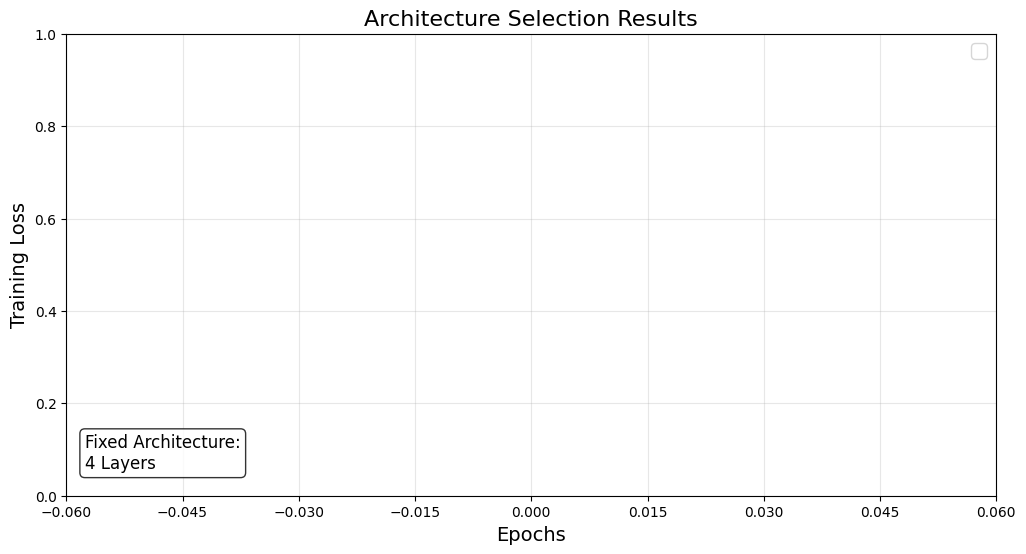

🏆 The winning architecture is: 4. Full Architecture (Loss: 0.7707)


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Define a new set of colors for the plot
new_colors = ['dodgerblue', 'mediumorchid', 'forestgreen', 'orange']
experiment_new_names = ["No Re-Uploading & No Environment Qubits", "No Re-Uploading & Environment Qubits", 
                        "Re-Uploading & No Environment Qubits", "Re-Uploading & Environment Qubits"]
plt.figure(figsize=(12, 6))

# Loop through experiments and assign new colors
for i, exp in enumerate(experiments):
    name = exp[name]
    # Override the color defined in the experiment dictionary
    color = new_colors[i % len(new_colors)]
    
    if name in results:
        history = results[name]
        name = experiment_new_names[i]
        plt.plot(history, label=name, color=color, linewidth=2, marker='o', markersize=3)

# --- Formatting ---
# 1. Force Integer Ticks on X-Axis
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

# 2. Increase margins so the text doesn't get cut off
plt.margins(x=0.1)

plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Training Loss", fontsize=14)
plt.title("Architecture Selection Results", fontsize=16)
plt.legend(fontsize=14)
plt.grid(True, alpha=0.3)

# Add a text box with the architecture settings
info_text = f"Fixed Architecture:\n4 Layers"
plt.text(0.02, 0.05, info_text, transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))


plt.show()

# Print Winner
if results:
    final_losses = {k: v[-1] for k, v in results.items()}
    winner = min(final_losses, key=final_losses.get)
    print(f"🏆 The winning architecture is: {winner} (Loss: {final_losses[winner]:.4f})")

In [14]:
import optax
import time
import jax
import jax.numpy as jnp
import jax.random as random
import pennylane as qml
from math import comb

# --- PHASE B CONFIGURATION ---
# We use the winner from Phase A:
# winner: NO Re-uploading, YES Condition Env
USE_REUPLOAD_B = False
COND_ENV_B = True 

N_EPOCHS_B = 50        # Short run to check capacity
N_SUBSET_B = 400      # Small data subset for speed

# Configurations to sweep: (Layers, Ancillas)
configs = [
    (4, 0), # Baseline (Shallow, Narrow)
    (4, 3), # Wide
    (6, 0), # Deep
    (6, 3), # Deep & Wide
    (8, 0), # Very Deep
    (8, 3)  # Very Deep & Wide
]

# Prepare Data
X_b = X_bits[:N_SUBSET_B]
P_b = Props[:N_SUBSET_B]
Y_b = Y_ind[:N_SUBSET_B]

results_b = {}

print(f"Starting Phase B: Capacity Sweep")
print(f"Fixed Arch: Re-uploading={USE_REUPLOAD_B} | Condition Env={COND_ENV_B}")
print(f"Configs (L, A): {configs}")

for (n_layers_run, n_ancillas_run) in configs:
    config_name = f"L{n_layers_run}_A{n_ancillas_run}"
    print(f"\n=============================================")
    print(f"Running Config: {config_name}")
    print(f"Layers: {n_layers_run} | Ancillas: {n_ancillas_run}")
    
    # --- 1. DYNAMIC CIRCUIT CONSTRUCTION ---
    
    # Define wire names for this run
    current_token_wires = [f"token_{i}" for i in range(BITS_PER_TOKEN)]
    current_ancilla_wires = [f"ancilla_{i}" for i in range(n_ancillas_run)]
    
    current_tw_aw = current_token_wires + current_ancilla_wires
    current_all_wires = prop_wires + current_tw_aw
    
    # Create NEW Device
    dev_run = qml.device("default.qubit", wires=current_all_wires)
    
    # Calculate Shapes
    n_total_qubits = len(current_tw_aw)
    n_strings_run = sum(comb(n_total_qubits, k) for k in range(1, 4)) # H_local=3
    
    targets_run = current_tw_aw if COND_ENV_B else current_token_wires
    n_dense_params = len(prop_wires) * len(targets_run)
    
    # Initialize Parameters
    key = random.PRNGKey(42)
    key, k_emb, k_WQ, k_WK, k_WV, k_theta, k_gamma, k_sigma = jax.random.split(key, 8)
    
    init_params = {
        'theta': jax.random.normal(k_theta, (n_layers_run, n_total_qubits, 3)) * 0.1,
        'gamma': jax.random.normal(k_gamma, (n_layers_run, n_dense_params)) * 0.1,
        'sigma': jax.random.normal(k_sigma, (n_layers_run, n_strings_run)) * 0.01,
        'embedding_table': jax.random.normal(k_emb, (VOCABULARY_SIZE, n_total_qubits)) * 0.1,
        'W_Q': jax.random.normal(k_WQ, (n_total_qubits, BITS_PER_TOKEN)) * 0.1,
        'W_K': jax.random.normal(k_WK, (n_total_qubits, BITS_PER_TOKEN)) * 0.1,
        'W_V': jax.random.normal(k_WV, (n_total_qubits, BITS_PER_TOKEN)) * 0.1
    }
    
    optimizer = optax.adamw(learning_rate=0.001, weight_decay=1e-2)
    opt_state = optimizer.init(init_params)
    
    # --- 2. DEFINE QNODE FOR THIS CONFIG ---
    @qml.qnode(dev_run, interface="jax", diff_method="backprop")
    def run_circuit(token_bits, props, theta, gamma, sigma, ctx):
        # A. Encoders
        for i in range(len(token_bits)):
            qml.RX(token_bits[i] * jnp.pi, wires=current_token_wires[i])
        
        for i, val in enumerate(props):
            qml.RY(val, wires=prop_wires[i])
            
        # Attention Injection (Start only)
        for i, val in enumerate(ctx):
            qml.RY(val, wires=current_token_wires[i])
            
        # B. Layers
        for l in range(n_layers_run):
            # Dense Connection
            param_idx = 0
            for pw in prop_wires:
                for tw in targets_run:
                    qml.CRX(gamma[l, param_idx], wires=[pw, tw])
                    param_idx += 1
            
            # Backbone
            for i, w in enumerate(current_tw_aw):
                qml.RX(theta[l, i, 0], wires=w)
                qml.RY(theta[l, i, 1], wires=w)
                qml.RZ(theta[l, i, 2], wires=w)
            
            n_w = len(current_tw_aw)
            for i in range(n_w):
                qml.CNOT(wires=[current_tw_aw[i], current_tw_aw[(i+1)%n_w]])
                
            # Sigma Layer (Simplified reconstruction)
            from itertools import combinations
            combos = []
            for k in range(1, 4):
                 combos.extend(combinations(range(n_total_qubits), k))
            
            for i, comb_indices in enumerate(combos):
                wires_subset = [current_tw_aw[idx] for idx in comb_indices]
                qml.MultiRZ(sigma[l, i], wires=wires_subset)

        return qml.probs(wires=current_token_wires)

    # --- 3. WRAPPER & TRAINING STEP ---
    
    # FIX: Wrapper to unpack parameters correctly
    def single_step_run(p, x, props, ctx):
        return run_circuit(x, props, p['theta'], p['gamma'], p['sigma'], ctx)
    
    # Vectorize the WRAPPER, not the QNode directly
    batch_predict_run = jax.vmap(
        jax.vmap(single_step_run, in_axes=(None, 0, None, 0)), 
        in_axes=(None, 0, 0, 0)
    )

    @jax.jit
    def train_step_run(params, opt_state, x_bits, props, y_idx):
        def loss_fn(p):
            x_indices = jax.vmap(jax.vmap(bits_to_index))(x_bits)
            input_embeddings = p['embedding_table'][x_indices]
            
            # Simplified Positional Encoding
            x_i_pos = input_embeddings 
            
            Q = x_i_pos @ p['W_Q']
            K = x_i_pos @ p['W_K']
            V = x_i_pos @ p['W_V']
            output_context = batched_causal_attention(Q, K, V)
            
            # Correctly call the wrapped function
            pred_probs = batch_predict_run(p, x_bits, props, output_context)
            
            loss, _ = total_loss_fn(pred_probs, y_idx)
            return loss

        loss, grads = jax.value_and_grad(loss_fn)(params)
        updates, new_opt_state = optimizer.update(grads, opt_state, params)
        new_params = optax.apply_updates(params, updates)
        return new_params, loss, new_opt_state

    # --- 4. EXECUTE RUN ---
    loss_history = []
    
    params = init_params
    
    for epoch in range(N_EPOCHS_B):
        # Shuffle
        key, subkey = random.split(key)
        perm = random.permutation(subkey, N_SUBSET_B)
        X_shuff = X_b[perm]
        P_shuff = P_b[perm]
        Y_shuff = Y_b[perm]
        
        total_loss = 0.0
        
        for step in range(0, N_SUBSET_B, BATCH_SIZE):
            idx_end = min(step + BATCH_SIZE, N_SUBSET_B)
            params, loss, opt_state = train_step_run(
                params, opt_state, 
                X_shuff[step:idx_end], 
                P_shuff[step:idx_end], 
                Y_shuff[step:idx_end]
            )
            total_loss += loss * (idx_end - step)
            
        avg_loss = total_loss / N_SUBSET_B
        loss_history.append(avg_loss)
        
        if epoch % 5 == 0:
            print(f"  Ep {epoch:02d} | Loss: {avg_loss:.4f}")

    print(f"  > Final Loss: {loss_history[-1]:.4f}")
    results_b[config_name] = loss_history

print("\nPhase B Complete.")

Starting Phase B: Capacity Sweep
Fixed Arch: Re-uploading=False | Condition Env=True
Configs (L, A): [(4, 0), (4, 3), (6, 0), (6, 3), (8, 0), (8, 3)]

Running Config: L4_A0
Layers: 4 | Ancillas: 0
  Ep 00 | Loss: 1.8452
  Ep 05 | Loss: 1.1702
  Ep 10 | Loss: 0.9820
  Ep 15 | Loss: 0.8916
  Ep 20 | Loss: 0.8503
  Ep 25 | Loss: 0.8147
  Ep 30 | Loss: 0.7978
  Ep 35 | Loss: 0.7868
  Ep 40 | Loss: 0.7783
  Ep 45 | Loss: 0.7717
  > Final Loss: 0.7672

Running Config: L4_A3
Layers: 4 | Ancillas: 3
  Ep 00 | Loss: 1.5899
  Ep 05 | Loss: 1.0088
  Ep 10 | Loss: 0.8663
  Ep 15 | Loss: 0.8229
  Ep 20 | Loss: 0.7987
  Ep 25 | Loss: 0.7772
  Ep 30 | Loss: 0.7629
  Ep 35 | Loss: 0.7522
  Ep 40 | Loss: 0.7436
  Ep 45 | Loss: 0.7364
  > Final Loss: 0.7303

Running Config: L6_A0
Layers: 6 | Ancillas: 0
  Ep 00 | Loss: 1.5429
  Ep 05 | Loss: 0.9794
  Ep 10 | Loss: 0.8629
  Ep 15 | Loss: 0.8202
  Ep 20 | Loss: 0.7853
  Ep 25 | Loss: 0.7635
  Ep 30 | Loss: 0.7457
  Ep 35 | Loss: 0.7295
  Ep 40 | Loss: 0.7

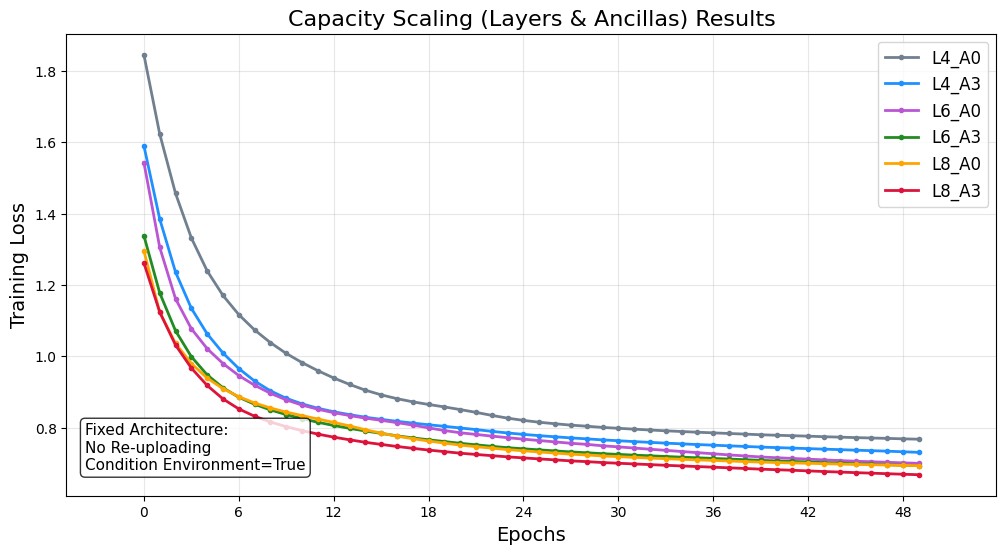


🏆 WINNING CONFIGURATION: L8_A3
   Final Loss: 0.6676
   -> Use N_LAYERS = 8
   -> Use n_ancillas = 3


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Define distinct colors for the configurations
colors = ['slategray', 'dodgerblue', 'mediumorchid', 'forestgreen', 'orange', 'crimson']

plt.figure(figsize=(12, 6))
offset_y = 12
# Loop through the stored results
for i, (config_name, history) in enumerate(results_b.items()):
    color = colors[i % len(colors)]
    
    # Plot Loss Curve
    plt.plot(history, label=config_name, color=color, linewidth=2, marker='o', markersize=3)

# --- Formatting ---
# 1. Force Integer Ticks on X-Axis
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

# 2. Increase margins so the text doesn't get cut off
plt.margins(x=0.1) 

plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Training Loss", fontsize=14)
plt.title("Capacity Scaling (Layers & Ancillas) Results", fontsize=16)
plt.legend(fontsize=12, loc='upper right')
plt.grid(True, alpha=0.3)

# Add a text box with the architecture settings
info_text = f"Fixed Architecture:\nNo Re-uploading\nCondition Environment=True"
plt.text(0.92, 0.75, info_text, transform=plt.gca().transAxes, 
         fontsize=11, verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.show()

# --- Print the Winner ---
if results_b:
    final_losses = {k: v[-1] for k, v in results_b.items()}
    winner = min(final_losses, key=final_losses.get)
    print(f"\n🏆 WINNING CONFIGURATION: {winner}")
    print(f"   Final Loss: {final_losses[winner]:.4f}")
    
    import re
    match = re.search(r"L(\d+)_A(\d+)", winner)
    if match:
        best_L = int(match.group(1))
        best_A = int(match.group(2))
        print(f"   -> Use N_LAYERS = {best_L}")
        print(f"   -> Use n_ancillas = {best_A}")

In [ ]:
print("\nData Loading Complete.")